In [50]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformações para normalizar o MNIST (0 a 1 e normalização)
transform = transforms.Compose([
    transforms.ToTensor(),  # converte para tensor e normaliza para [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # média e desvio padrão do MNIST
])

# Baixar e carregar os dados de treino e teste
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# Criar os dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Verificar um lote
images, labels = next(iter(train_loader))
print(f'Formato das imagens: {images.shape}')
print(f'Rótulos: {labels[:10]}')


Formato das imagens: torch.Size([64, 1, 28, 28])
Rótulos: tensor([0, 8, 9, 5, 0, 9, 6, 8, 2, 3])


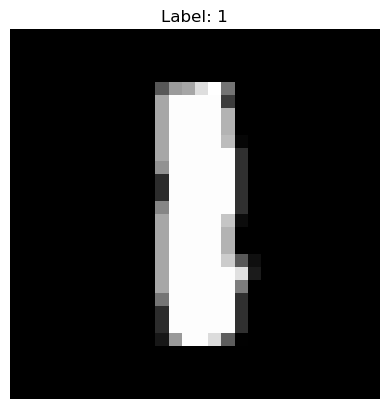

In [51]:
import matplotlib.pyplot as plt
import random

# Seleciona um índice aleatório
idx = random.randint(0, len(train_dataset) - 1)

# Pega a imagem e o rótulo correspondente
image, label = train_dataset[idx]


# Mostra a imagem
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()
